In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import librosa
import librosa.display
import IPython.display as ipd

from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Dense, Flatten, Dropout, SeparableConv1D, Activation

import warnings
warnings.filterwarnings('ignore')

In [ ]:
diagnosis_df = pd.read_csv('/content/drive/MyDrive/DATASETS/LUNG SOUND DB/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',
                           names=['Patient number', 'Diagnosis'])

In [ ]:
diagnosis_df.head(8)

,Patient number,Diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
5,106,COPD
6,107,COPD
7,108,LRTI


In [ ]:
patient_df = pd.read_csv('/content/drive/MyDrive/DATASETS/LUNG SOUND DB/demographic_info.txt',
                         names=['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                         delimiter = ' ')

In [ ]:
patient_df.head()

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [ ]:
patient_df['Adult BMI (kg/m2)'].isna().sum()

51

In [ ]:
for i in range(len(patient_df)):
    if (pd.isna(patient_df['Adult BMI (kg/m2)'][i])) and (not pd.isna(patient_df['Child Weight (kg)'][i])) and (not pd.isna(patient_df['Child Height (cm)'][i])):
        patient_df['Adult BMI (kg/m2)'][i] = round(patient_df['Child Weight (kg)'][i]/np.square(0.01*patient_df['Child Height (cm)'][i]),2)

In [ ]:
patient_df['Adult BMI (kg/m2)'].isna().sum()

9

In [ ]:
df = pd.merge(left=patient_df, right=diagnosis_df, how='left')
df.head()

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,19.39,19.0,99.0,URTI
1,102,0.75,F,18.39,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,17.56,32.0,135.0,URTI


In [ ]:
Patient_numbers, Recording_indices, Chest_locations, Acquisition_modes, Recording_equipments = [], [], [], [], []
folder_path = '/content/drive/MyDrive/DATASETS/LUNG SOUND DB/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        parts = filename.split('_')
        Patient_number = parts[0]
        Recording_index = parts[1]
        Chest_location = parts[2]
        Acquisition_mode = parts[3]
        Recording_equipment = parts[4].split('.')[0]

        Patient_numbers.append(int(Patient_number))
        Recording_indices.append(Recording_index)
        Chest_locations.append(Chest_location)
        Acquisition_modes.append(Acquisition_mode)
        Recording_equipments.append(Recording_equipment)

df1 = pd.DataFrame({'Patient number': Patient_numbers, 'Recording index': Recording_indices, 'Chest location': Chest_locations,
                    'Acquisition mode': Acquisition_modes, 'Recording equipment': Recording_equipments})

In [ ]:
df1.tail()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
915,158,2p3,Tc,mc,AKGC417L
916,158,1p4,Lr,mc,AKGC417L
917,160,1b3,Al,mc,AKGC417L
918,160,1b3,Pl,mc,AKGC417L
919,160,1b2,Al,mc,AKGC417L


In [ ]:
df_all = pd.merge(left=df1, right=df, how='left').sort_values('Patient number').reset_index(drop=True)
df_all.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,1b1,Pr,sc,Meditron,3.00,F,19.39,19.0,99.0,URTI
1,101,1b1,Al,sc,Meditron,3.00,F,19.39,19.0,99.0,URTI
2,102,1b1,Ar,sc,Meditron,0.75,F,18.39,9.8,73.0,Healthy
3,103,2b2,Ar,mc,LittC2SE,70.00,F,33.00,NaN,NaN,Asthma
4,104,1b1,Ar,sc,Litt3200,70.00,F,28.47,NaN,NaN,COPD


In [ ]:
def parser(row):
    # path of the file
    file_name = os.path.join('/content/drive/MyDrive/DATASETS/LUNG SOUND DB/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files',
                            str(row['Patient number']) +'_'+ str(row['Recording index']) +'_'+ str(row['Chest location'])
                             +'_'+ str(row['Acquisition mode']) +'_'+ str(row['Recording equipment']) + '.wav')
    # load the audio file
    y, sr = librosa.load(file_name)
    # extract features from the data
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=70).T, axis=0)
    feature = mfccs
    label = row['Diagnosis']

    return [feature, label]

In [ ]:
data = df_all.apply(parser, axis=1)
data.columns = ['feature','label']

In [ ]:
data[0]

[array([-5.8250470e+02,  9.5394707e+01,  5.7402180e+01,  3.1435293e+01,
         2.8148779e+01,  3.3527462e+01,  3.1569719e+01,  2.2792303e+01,
         1.6643297e+01,  1.5632529e+01,  1.4031043e+01,  9.2721281e+00,
         5.8467088e+00,  7.3350210e+00,  1.0574074e+01,  1.0616122e+01,
         7.1645789e+00,  3.7286332e+00,  2.6651757e+00,  3.6501770e+00,
         5.4980607e+00,  7.3725867e+00,  8.1013985e+00,  6.5084467e+00,
         3.1660833e+00,  6.6651762e-01,  9.0888029e-01,  3.0851729e+00,
         4.8948326e+00,  5.0404840e+00,  3.8096790e+00,  2.2250612e+00,
         1.2050955e+00,  1.2793610e+00,  2.2250681e+00,  3.1019638e+00,
         3.0208256e+00,  2.1977162e+00,  1.7298222e+00,  2.2531002e+00,
         3.1094573e+00,  3.2221007e+00,  2.3043470e+00,  1.0478951e+00,
         2.6495790e-01,  2.6520228e-01,  8.3647752e-01,  1.6237062e+00,
         2.2457595e+00,  2.3997288e+00,  2.0386701e+00,  1.4888310e+00,
         1.1221051e+00,  1.0775858e+00,  1.1935260e+00,  1.17769

In [ ]:
# input split
X = np.array(list(zip(*data))[0])
y = np.array(list(zip(*data))[1])

In [ ]:
X.shape

(920, 70)

In [ ]:
X[0]

array([-5.8250470e+02,  9.5394707e+01,  5.7402180e+01,  3.1435293e+01,
        2.8148779e+01,  3.3527462e+01,  3.1569719e+01,  2.2792303e+01,
        1.6643297e+01,  1.5632529e+01,  1.4031043e+01,  9.2721281e+00,
        5.8467088e+00,  7.3350210e+00,  1.0574074e+01,  1.0616122e+01,
        7.1645789e+00,  3.7286332e+00,  2.6651757e+00,  3.6501770e+00,
        5.4980607e+00,  7.3725867e+00,  8.1013985e+00,  6.5084467e+00,
        3.1660833e+00,  6.6651762e-01,  9.0888029e-01,  3.0851729e+00,
        4.8948326e+00,  5.0404840e+00,  3.8096790e+00,  2.2250612e+00,
        1.2050955e+00,  1.2793610e+00,  2.2250681e+00,  3.1019638e+00,
        3.0208256e+00,  2.1977162e+00,  1.7298222e+00,  2.2531002e+00,
        3.1094573e+00,  3.2221007e+00,  2.3043470e+00,  1.0478951e+00,
        2.6495790e-01,  2.6520228e-01,  8.3647752e-01,  1.6237062e+00,
        2.2457595e+00,  2.3997288e+00,  2.0386701e+00,  1.4888310e+00,
        1.1221051e+00,  1.0775858e+00,  1.1935260e+00,  1.1776911e+00,
      

In [ ]:
y[:10]

array(['URTI', 'URTI', 'Healthy', 'Asthma', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD'], dtype='<U14')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = to_categorical(y_encoded)

In [ ]:
y.shape

(920, 8)

In [ ]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
original_label = le.inverse_transform([np.argmax(y[100])])

print(original_label[0])

COPD


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
num_classes = 8

# model creation
model = Sequential()

model.add(Dense(256, input_shape=(70,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer='adam')

In [ ]:
idx = np.random.choice(range(len(X_test)))
X_testing = X_test[idx].reshape((1, 70))
# Make predictions
predictions = model.predict(X_testing)
# Get the predicted class index
predicted_class_index = np.argmax(predictions[0])
print('Index:', idx)
print("Predicted Class Index:", predicted_class_index)
original_label = le.inverse_transform([np.argmax(y_test[idx])])
predicted_class_label = le.inverse_transform([predicted_class_index])
print("Original Class Label:", original_label[0])
print("Predicted Class Label:", predicted_class_label[0])
#print(df_all.iloc[idx]['Diagnosis'])


1/1 [==============================] - 0s 362ms/step
Index: 41
Predicted Class Index: 0
Original Class Label: COPD
Predicted Class Label: Asthma


In [ ]:
# Train the model and store the training history
history = model.fit(X_train, y_train, batch_size=48, epochs=120, validation_split=0.25)

Epoch 1/120
11/11 [==============================] - 1s 77ms/step - loss: 0.3462 - accuracy: 0.8903 - val_loss: 0.4636 - val_accuracy: 0.8634
Epoch 2/120
11/11 [==============================] - 0s 42ms/step - loss: 0.3156 - accuracy: 0.8841 - val_loss: 0.4322 - val_accuracy: 0.8820
Epoch 3/120
11/11 [==============================] - 1s 54ms/step - loss: 0.3149 - accuracy: 0.8882 - val_loss: 0.5468 - val_accuracy: 0.8634
Epoch 4/120
11/11 [==============================] - 1s 54ms/step - loss: 0.2789 - accuracy: 0.8965 - val_loss: 0.4369 - val_accuracy: 0.8820
Epoch 5/120
11/11 [==============================] - 1s 48ms/step - loss: 0.3083 - accuracy: 0.8923 - val_loss: 0.7286 - val_accuracy: 0.8571
Epoch 6/120
11/11 [==============================] - 1s 57ms/step - loss: 0.2933 - accuracy: 0.8965 - val_loss: 0.4102 - val_accuracy: 0.8820
Epoch 7/120
11/11 [==============================] - 1s 47ms/step - loss: 0.2722 - accuracy: 0.8986 - val_loss: 0.4460 - val_accuracy: 0.8696
Epoch 

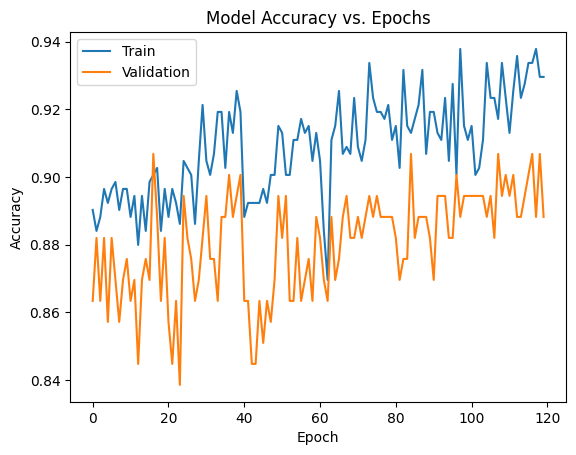

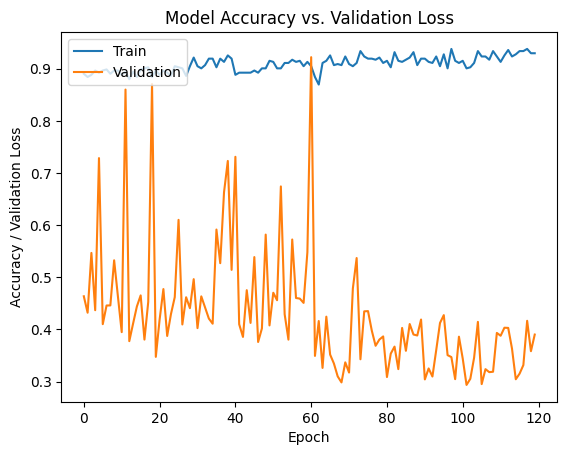

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy versus epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot accuracy versus validation loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Validation Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [ ]:
# Checking model performance
from sklearn.metrics import confusion_matrix, classification_report
predictions = model.predict(X_test)

predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(np.argmax(y_test, axis=1), predicted_classes))

9/9 [==============================] - 0s 4ms/step
Confusion Matrix:
[[  7   0   2   0   0   0]
 [  2   0   0   0   0   3]
 [  2   0 227   0   1   0]
 [  0   0   2   0   0  11]
 [  0   0   8   0   4   2]
 [  1   0   2   0   0   2]]

Classification Report:
              precision    recall  f1-score   support

           1       0.58      0.78      0.67         9
           2       0.00      0.00      0.00         5
           3       0.94      0.99      0.96       230
           4       0.00      0.00      0.00        13
           6       0.80      0.29      0.42        14
           7       0.11      0.40      0.17         5

    accuracy                           0.87       276
   macro avg       0.41      0.41      0.37       276
weighted avg       0.85      0.87      0.85       276



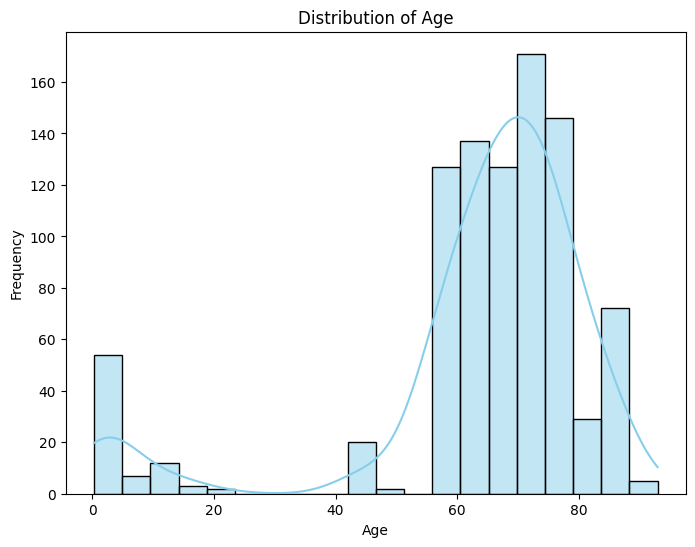

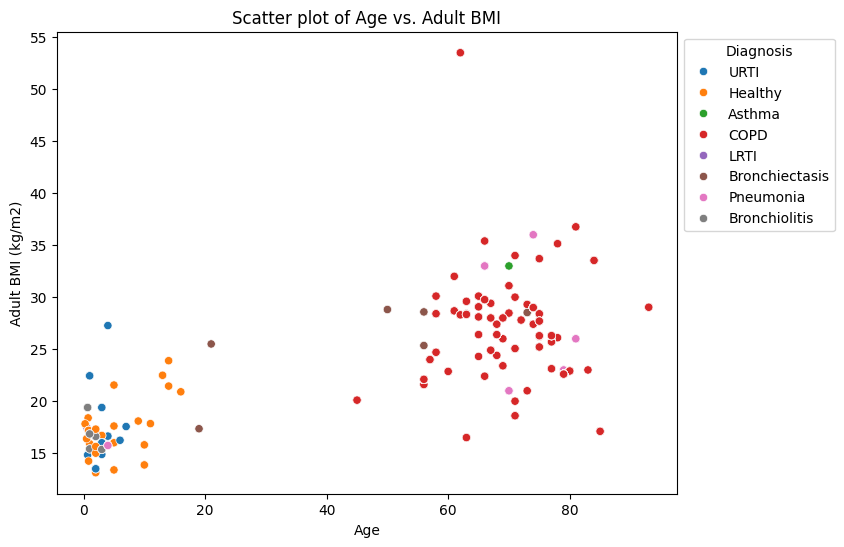

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Univariate graph - Histogram
plt.figure(figsize=(8, 6))
sns.histplot(df_all['Age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Bivariate graph - Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='Adult BMI (kg/m2)', data=df_all, hue='Diagnosis')
plt.title('Scatter plot of Age vs. Adult BMI')
plt.xlabel('Age')
plt.ylabel('Adult BMI (kg/m2)')
plt.legend(title='Diagnosis', bbox_to_anchor=(1, 1))
plt.show()


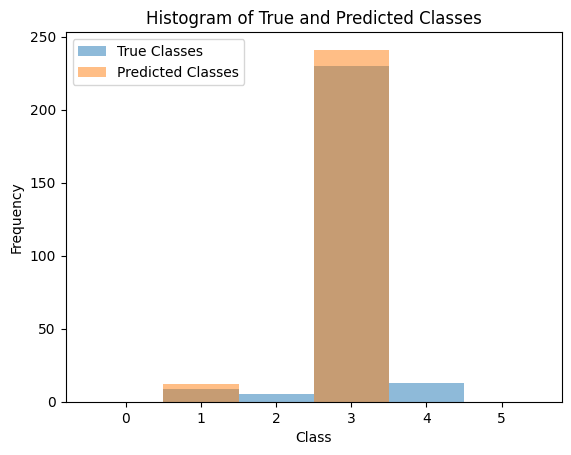

In [ ]:
import matplotlib.pyplot as plt

# Get the true class labels from y_test
true_classes = np.argmax(y_test, axis=1)

# Plot histogram for true classes
plt.hist(true_classes, bins=np.arange(len(np.unique(true_classes)) + 1) - 0.5, alpha=0.5, label='True Classes')

# Plot histogram for predicted classes
plt.hist(predicted_classes, bins=np.arange(len(np.unique(predicted_classes)) + 1) - 0.5, alpha=0.5, label='Predicted Classes')

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of True and Predicted Classes')
plt.legend()
plt.show()
